In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data = pd.read_csv("sales_train.csv")
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
data['date'] = pd.to_datetime(data['date'], format = '%d.%m.%Y')
ori_data=data
data = data.groupby('date').sum()['item_cnt_day']
ori_data=ori_data.groupby('date').sum()['item_cnt_day']

TEST stationarity with adfuller test and draw rolling average picture

In [3]:
def draw_rolling_average(data):
    data_mean=pd.rolling_mean(data,window=30)
    data_std=pd.rolling_std(data,window=30)
    plt.plot(data,label='Original')
    plt.plot(data_mean, label='Rolling Mean')
    plt.plot(data_std, label = 'Rolling Std')
    plt.legend()
    plt.show()

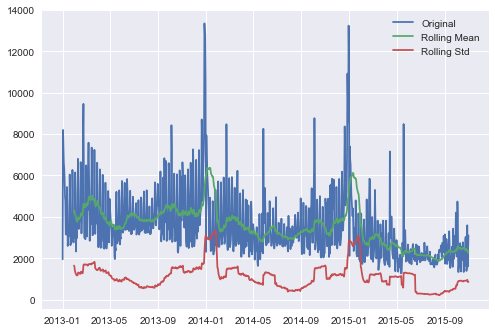

In [4]:
draw_rolling_average(data)

In [5]:
def DF_test(data):
    result = adfuller(data,autolag='AIC')
    print('Test Statistic:',result[0])
    print('p-value:',result[1])
    print('Lags Used:',result[2])
    print('Observations Used:',result[3])
    for key,value in result[4].items():
        print('Critical Value (%s)'%key, value)

In [6]:
DF_test(data)

Test Statistic: -4.045604237566621
p-value: 0.001189666158171624
Lags Used: 21
Observations Used: 1012
Critical Value (1%) -3.436828225807217
Critical Value (5%) -2.8644002004847144
Critical Value (10%) -2.568292900881126


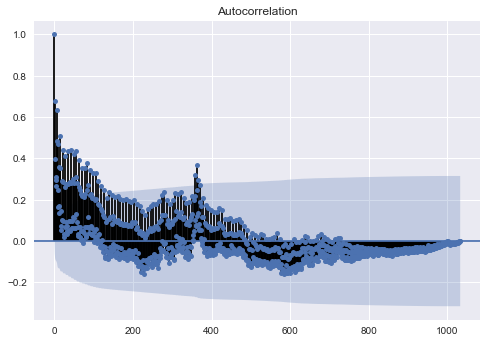

In [7]:
plot_acf(data)
plt.show()

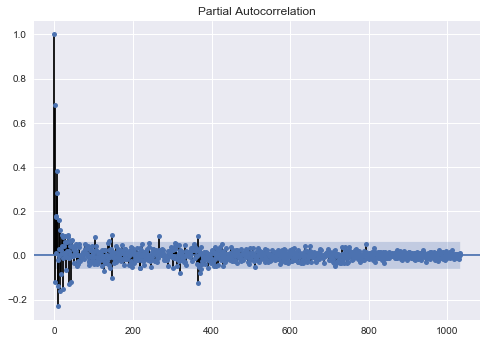

In [8]:
plot_pacf(data)
plt.show()

decompose the trend and stationarity 

First Logarithm

/Users/shihongliang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/shihongliang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


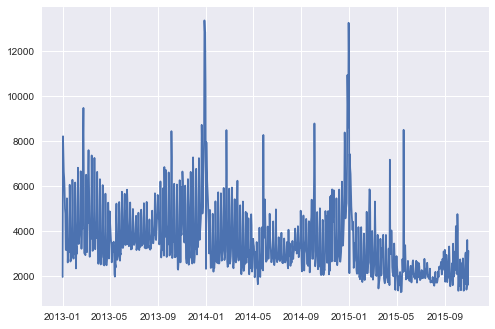

In [9]:
data_log=np.log(data)
data_log_scaled = scaler.fit_transform(data_log)
plt.plot(data)
plt.show()

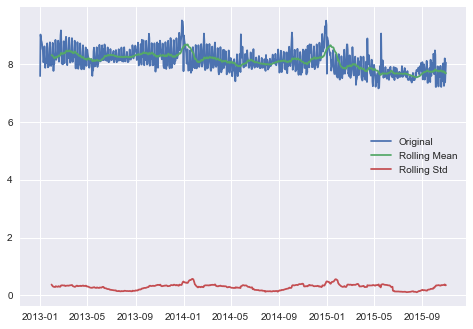

In [10]:
draw_rolling_average(data_log)

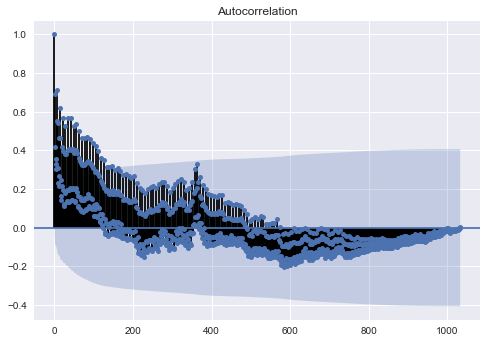

In [11]:
plot_acf(data_log)
plt.show()

moving average 

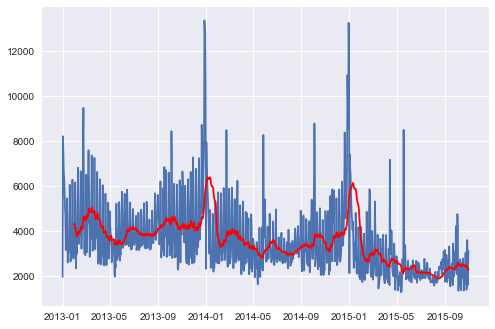

In [12]:
moving_average = pd.rolling_mean(data,30)
plt.plot(data)
plt.plot(moving_average, color='red')
plt.show()

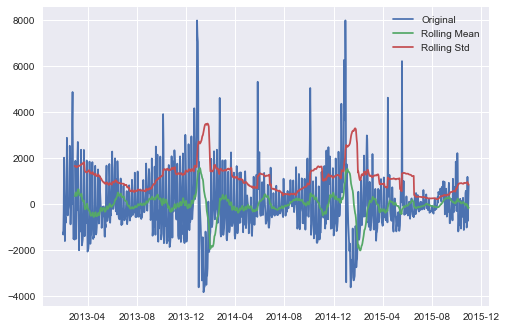

Test Statistic: -8.625276339599173
p-value: 5.953592152769708e-14
Lags Used: 22
Observations Used: 982
Critical Value (1%) -3.4370266558635914
Critical Value (5%) -2.864487711945291
Critical Value (10%) -2.5683395116993872


In [13]:
avg_diff = data - moving_average
avg_diff.dropna(inplace=True)
draw_rolling_average(avg_diff)
DF_test(avg_diff)

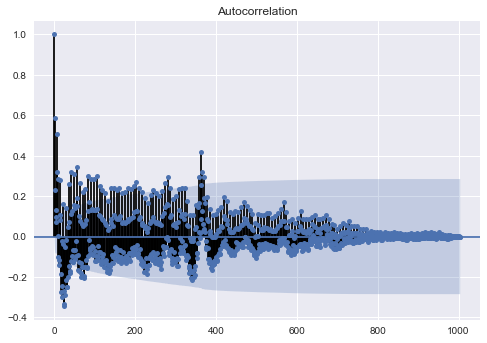

In [14]:
plot_acf(avg_diff)
plt.show()

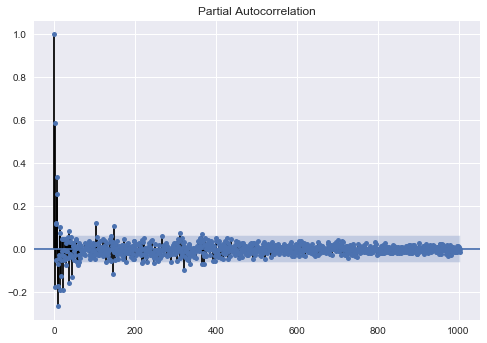

In [15]:
plot_pacf(avg_diff)
plt.show()

EWMA

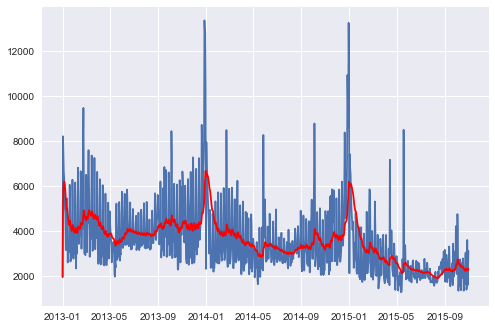

In [16]:
avg_weight = pd.ewma(data, halflife=12)
plt.plot(data)
plt.plot(avg_weight, color='red')
plt.show()

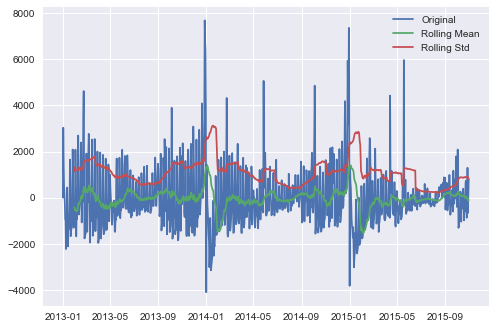

Test Statistic: -7.666308878104179
p-value: 1.6376787488538756e-11
Lags Used: 21
Observations Used: 1012
Critical Value (1%) -3.436828225807217
Critical Value (5%) -2.8644002004847144
Critical Value (10%) -2.568292900881126


In [17]:
ewma_diff = data - avg_weight
draw_rolling_average(ewma_diff)
DF_test(ewma_diff)

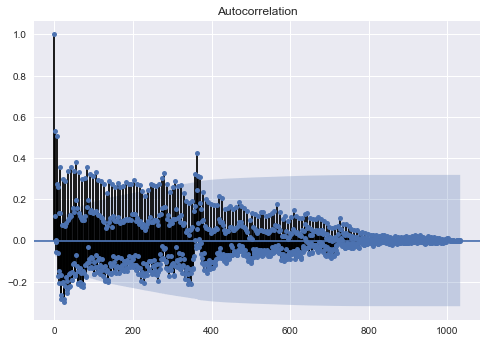

In [18]:
plot_acf(ewma_diff)
plt.show()

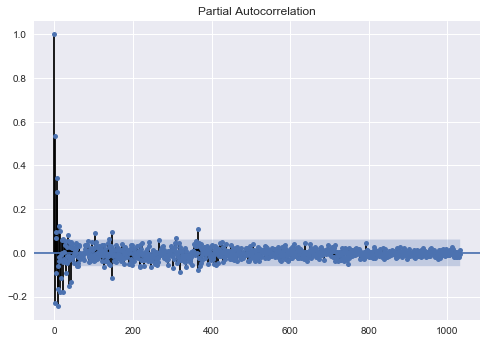

In [19]:
plot_pacf(ewma_diff)
plt.show()

decompose seasonarity 

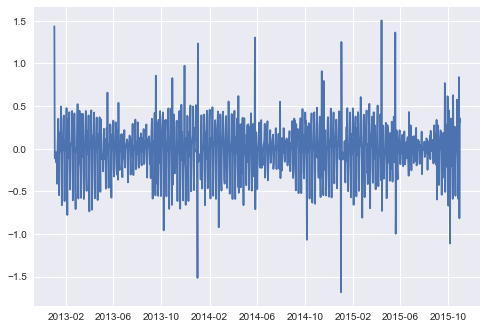

In [20]:
data_diff = data_log - data_log.shift()
plt.plot(data_diff)
plt.show()

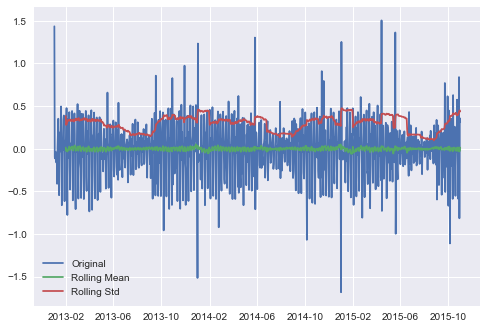

Test Statistic: -8.875396418925908
p-value: 1.3623351374725232e-14
Lags Used: 20
Observations Used: 1012
Critical Value (1%) -3.436828225807217
Critical Value (5%) -2.8644002004847144
Critical Value (10%) -2.568292900881126


In [21]:
data_diff.dropna(inplace=True)
draw_rolling_average(data_diff)
DF_test(data_diff)

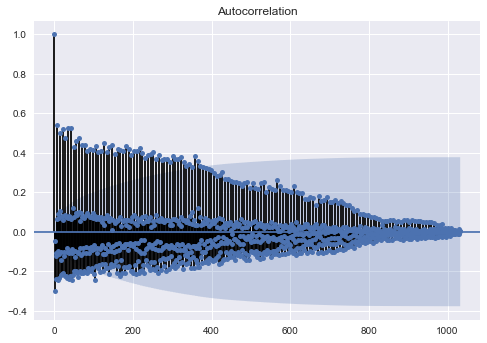

In [22]:
plot_acf(data_diff)
plt.show()

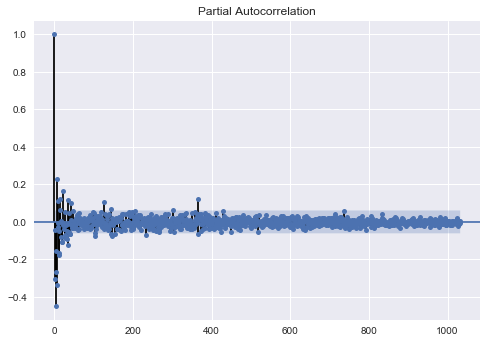

In [23]:
plot_pacf(data_diff)
plt.show()

white noise test

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox
result = acorr_ljungbox(data_log, lags=1)

In [25]:
result

(array([498.29821586]), array([2.22969482e-110]))

P - value 显著小于0.05 为非白噪声序列

search the best P Q value

In [26]:
def test_p_q(data):
    pmax = int(len(data_log)/100)
    qmax = int(len(data_log)/100)
    bic_matrix = [] 
    for p in range(pmax+1):
      tmp = []
      for q in range(qmax+1):
        try: 
          tmp.append(ARIMA(data_log, (p,1,q)).fit().bic)
        except:
          tmp.append(None)
      bic_matrix.append(tmp)
    bic_matrix = pd.DataFrame(bic_matrix)
    p,q = bic_matrix.stack().idxmin() 
    print(u'BIC最小的p值和q值为：%s、%s' %(p,q)) 

In [27]:
def Draw_pre(newres):
    plt.figure(figsize=(40,10)) 
    plt.plot(ori_data,color='green',label='original')
    plt.plot(newres,color='black',label='predict')
    plt.legend()
    plt.show()

/Users/shihongliang/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


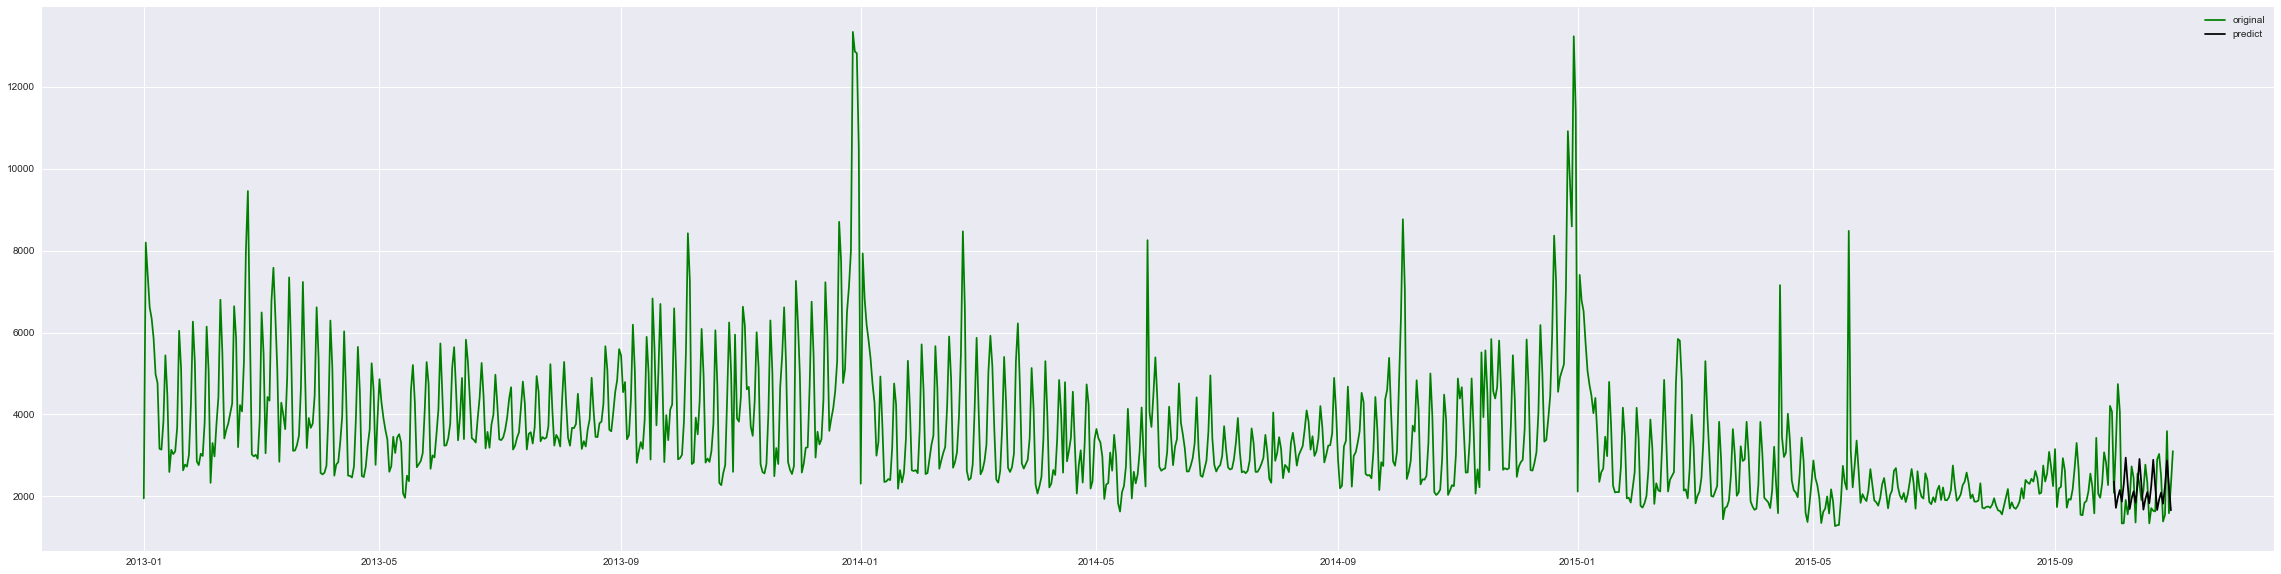

In [28]:
model = ARIMA(data_log, (9,1,8)).fit() 
res=model.forecast(30)[0] 
newres=np.exp(res)
newres = pd.DataFrame(newres)
newres.index=pd.date_range('2015-10-01','2015-10-30')
Draw_pre(newres)

In [36]:
predict = model.predict()
MSE = ((predict-data)**2).sum()/data_log.size
MSE

14405600.208704483

In [37]:
#moving average 
#test_p_q(avg_diff)

In [38]:
model = ARIMA(avg_diff, (3,0,2)).fit() 

In [39]:
predict = model.predict()
#predict =np.exp(predict)
MSE = ((predict-data)**2).sum()/data.size
MSE

13831633.274572415

In [40]:
#test_p_q(ewma_diff)

In [41]:
#EWMA
ewma_diff.dropna(inplace=True)
model = ARIMA(ewma_diff,(3,0,2)).fit()


In [42]:
predict = model.predict()
MSE = ((predict-data)**2).sum()/data.size
MSE

14405600.208704483